# Text Classification: Supervised Learning Models

In this notebook I am applying different supervised machine learning models to extract both hard and soft skills from job post descriptions.

## Table of contents

1. [Environment](#Environment)
   1. [Imports and Datasets](#Imports-and-Datasets)
   2. [Under-sampling](#Under-sampling)
   3. [Dataset Preparation](#Dataset-Preparation)
2. [Models and Training](#Models-and-Training)
   1. [Bag-of-Words](#Bag-of-Words)
   2. [Configuration](#Configuration)
   3. [Null Accuracy](#Null-Accuracy)
   4. [BoW Optimization](#BoW-Optimization)
   5. [Cross-Validation](#Cross-Validation)
   6. [Hyperparameter Tuning](#Hyperparameter-Tuning)
   7. [Training Using GridSeach](#Training-Using-GridSeach)
3. [Results and Visualizations](#Results-and-Visualizations)
   1. [Noun Chunk Extraction](#Noun-Chunk-Extraction)
   2. [Predictions](#Predictions)
   3. [Wordcloud Visualizations](#Wordcloud-Visualizations)
   

## Environment

### Imports and Datasets

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import time
import numpy as np
import pandas as pd                # Data processing

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline
from wordcloud import WordCloud    # Wordcloud visualizations

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score

# Database imports
from modeling.database import MongoDB

# NLP imports
import spacy

Let's load the complete dataset as well as the training dataset. This set is contained within the `noun_chunks_classified.csv` file which contains<br>
noun phrases classified by "*not_skill*", "*hard_skill*", or "*soft_skill*".

In [3]:
db = MongoDB()
complete_df = pd.DataFrame(list(db.get_all_documents()))

In [4]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()

not_skill     3406
hard_skill     524
soft_skill      70
Name: type, dtype: int64

### Under-sampling

As we can see the data set is not balanced. By far the most records describe the "not_skill" category. Let's try some undersampling on the most available data.<br>
This is done to prevent the model from being biased towards the majority class and to improve its performance on the minority class.<br>
What is also important to say here, is that we could try to oversample the lowest class in a future edit.

<AxesSubplot: >

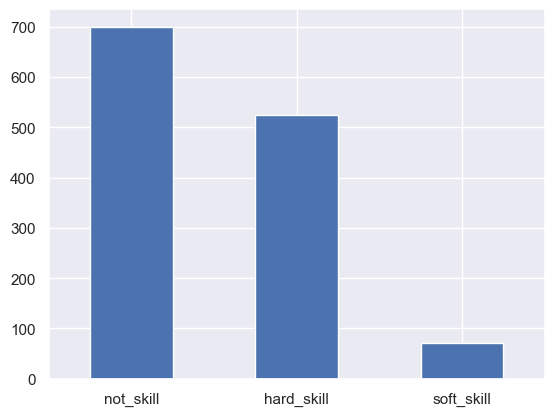

In [5]:
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=700)
df = pd.concat([df_skills, df_not_skills], ignore_index=True)

df['type'].value_counts().plot(kind='bar', rot=0)

### Dataset Preparation

Let's split the dataset into train and test sets for some initial fitting.

In [6]:
# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((905,), (389,))

## Models and Training

### Bag-of-Words

The `Bag-of-Words` model is a simplified representation of corpus collection, often used in natural language processing. It is the way to transform text into numeric representations, used by the classifiers. The most basic form of `BoW` is to represent text based on term frequency. The issue here is that the larger the matrix, the larger the feature matrix.

For this reason in information retrieval there is a better approach called `tf-idf` (term frequency–inverse document frequency). This model reflects the importance of a word in a document of the corpus.

In [7]:
vectorizer = TfidfVectorizer(stop_words='english')

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print(np.shape(X_train_vec), np.shape(X_test_vec))

(905, 1049) (389, 1049)


### Configuration

For this part I am going to train various classifiers and compare the training results. In detail the classifiers I will use are:

1. Multinomial Naive Bayes
2. Support Vector Machine
3. Linear Support Vector Machine
4. Random Forest
5. Logistic Regression

In [8]:
models = [
    MultinomialNB(),
    SVC(),
    LinearSVC(dual=False),
    RandomForestClassifier(),
    LogisticRegression()
]

Let's try to fit our models and measure the initial accuracy scores of the train and test sets.

In [9]:
measurements = []

for model in models:
    model.fit(X_train_vec, y_train)
    score_train = model.score(X_train_vec, y_train)
    score_test = model.score(X_test_vec, y_test)
    measurements.append([model.__class__.__name__, score_train, score_test])

results = pd.DataFrame(measurements, columns=['model', 'train_accuracy', 'test_accuracy'])
results

,model,train_accuracy,test_accuracy
0,MultinomialNB,0.902762,0.809769
1,SVC,0.976796,0.832905
2,LinearSVC,0.980110,0.822622
3,RandomForestClassifier,0.998895,0.827763
4,LogisticRegression,0.923757,0.825193


### Null Accuracy

Let's check the most basic comparison of our models against the null accuracy score. This score will tell us if the models perform better than just selecting the most frequent class every time.

In [10]:
# Null Accuracy
class_choices = y_test.value_counts()
null_accuracy = class_choices[0] / sum(class_choices)

print('Null accuracy score: {0:0.4f}\n'.format(null_accuracy))

Null accuracy score: 0.5373



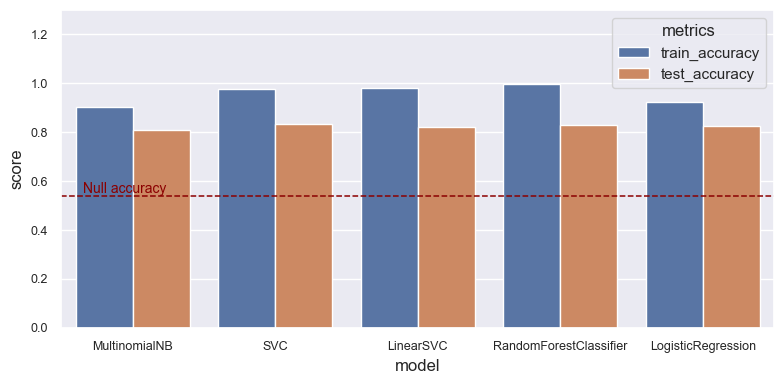

In [11]:
plt.figure(figsize=(8,4))

data_transformed = results.melt(id_vars='model', value_name='score', var_name='metrics')

metrics_plt = sns.barplot(data=data_transformed, x='model', y='score', hue='metrics')
metrics_plt.tick_params(labelsize=9)

plt.axhline(y=null_accuracy, ls='--', c='darkred', linewidth=1.1)
plt.text(-0.35, 0.55, 'Null accuracy', c='darkred', size='small')
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()

### BoW Optimization

We can observe that all of the models perform way better than the `null accuracy` score. It means we have good first predictions.<br>
Before we move on, let's see if we can improve these accuracies by fine tuning the TfIdf vectorizer.<br>
One way is to increase the amount of n-grams to include more combinations than just unigrams.<br>
We will also use the option `sublinear_tf` which is a form of penalty indicating that when a term is X times more frequent, it shouldn't be X times as important.<br>
The scoring metric we are going to use is the `f1_score` function. As this is a multi-class setting, we will need to use one of these settings:

- weighted (favours the majority class)
- micro (no favoring)
- macro (bigger penalty due to poor performance on minority classes)

For this example we will use the micro setting.

In [12]:
total_scores = {}
for n in range(1,11):
    # convert training data to bag of words
    vectorizer  = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, n), stop_words='english')
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)
    
    # train model and generate predictions
    scores = []
    for model in models:
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
    
        # compute f-1 score
        score = np.round(f1_score(y_test, y_pred, average='micro'), 5)
        scores.append(score)
        
    total_scores[n] = scores
    print(f'F1-score of n-gram range {n}: \t{total_scores[n]}')

F1-score of n-gram range 1: 	[0.81234, 0.8329, 0.82262, 0.83548, 0.82776]
F1-score of n-gram range 2: 	[0.82776, 0.84576, 0.8509, 0.80977, 0.83805]
F1-score of n-gram range 3: 	[0.83033, 0.84062, 0.85604, 0.80977, 0.84319]
F1-score of n-gram range 4: 	[0.82519, 0.83548, 0.85347, 0.80463, 0.84062]
F1-score of n-gram range 5: 	[0.82262, 0.8329, 0.85347, 0.79949, 0.83805]
F1-score of n-gram range 6: 	[0.82262, 0.83033, 0.85604, 0.81491, 0.83805]
F1-score of n-gram range 7: 	[0.82519, 0.82776, 0.85604, 0.82262, 0.83805]
F1-score of n-gram range 8: 	[0.82519, 0.82776, 0.85604, 0.80206, 0.83548]
F1-score of n-gram range 9: 	[0.82519, 0.82776, 0.85604, 0.8072, 0.83548]
F1-score of n-gram range 10: 	[0.82519, 0.82776, 0.85604, 0.79949, 0.83548]


Let's figure out the best range based on the average scores we found above.

In [13]:
best_ngram_range = (1, max(total_scores, key=lambda x: sum(total_scores[x])/len(total_scores[x])))
best_ngram_range

(1, 3)

In [14]:
vectorizer  = TfidfVectorizer(sublinear_tf=True, ngram_range=best_ngram_range, stop_words='english')
X_vec = vectorizer.fit_transform(X)

### Cross-Validation

Instead of utilizing the simple technique of *train-test-split*, another common practice is called **k-fold Cross-Validation** and aims to reduce overfitting.<br>
Cross-validation is a resampling procedure, which splits the data into **k** sets, and uses each set interchangably as the test set. It usually results to a less<br>
biased and less optimistic estimate of out models.

One popular value for **k** is the 10-fold Cross Validation.

In [15]:
# Get cross validated scores for input models
def get_cross_val_scores(models, x, y, cv=10, scoring='f1_micro'):
    measurements = [(model.__class__.__name__, i, score)
                    for model in models
                    for i, score in enumerate(cross_val_score(model, x, y, cv=cv, scoring=scoring))]

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'score'])
    return results

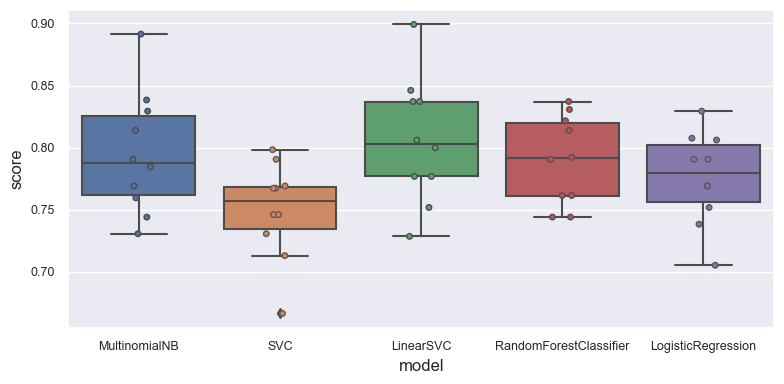

In [16]:
cv_results = get_cross_val_scores(models, X_vec, y)

plt.figure(figsize=(8,4))

cs_metrics_bxplt = sns.boxplot(x='model', y='score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [17]:
cv_results.groupby('model').score.mean().sort_values(ascending=False)

model
LinearSVC                 0.806047
MultinomialNB             0.795253
RandomForestClassifier    0.789809
LogisticRegression        0.775903
SVC                       0.749618
Name: score, dtype: float64

### Hyperparameter Tuning

The models we instatiated so far, could be potentially further improved by fine tuning their respective hyperparameter values. One process to perform hyperparameter<br>
tuning is called GridSearchCV, which exhaustively checks each pair of values to find the optimal. We will feed some sets of values to be checked into this process, as<br>
there is no way to find the best values for each hyperparameter in advance.

In [18]:
# Hyperparameter configurations for GridSearch
params_mnb = {'alpha': np.arange(0.01, 1, 0.01)}

params_svc = {'random_state': [0], 'C': np.arange(0.01, 1, 0.01), 'kernel': ['rbf','linear'], 'gamma': ['scale','auto'],
              'probability': [True,False], 'decision_function_shape': ['ovo','ovr']}

params_lsv = {'random_state': [0], 'dual': [True], 'C': np.arange(0.01, 1, 0.01), 'multi_class': ['ovr','crammer_singer']}

params_rfc = {'random_state': [0], 'n_jobs': [-1], 'n_estimators': [50,100,200], 'min_samples_leaf': [1,2],
              'max_depth': [None,5], 'min_samples_split': [2,5], 'oob_score': [True,False], 'warm_start': [True,False]}
              
params_lrc = {'random_state': [0], 'n_jobs': [-1], 'C': np.arange(0.01, 1, 0.01), 'warm_start': [True,False],
              'multi_class': ['multinomial']}

# Create the list of grid search models
grid_searches = [
    GridSearchCV(MultinomialNB(),          params_mnb, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(SVC(),                    params_svc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(LinearSVC(),              params_lsv, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(RandomForestClassifier(), params_rfc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1),
    GridSearchCV(LogisticRegression(),     params_lrc, cv=10, scoring="f1_micro", return_train_score=True, n_jobs=-1)
]

### Training Using GridSeach

In [19]:
# Try to fit the models using the Grid Search and update models with optimal hyperparameters
index = 0
gs_scores = []
for gs in grid_searches:
    model_name = models[index].__class__.__name__
    
    start = time.time()
    gs.fit(X_vec, y)
    end = time.time()
    
    print(f'GridSearch for {model_name} finished after {round(end-start, 2)} seconds. Best parameters found:')
    print(f'{gs.best_params_}\n')
    
    models[index] = gs.best_estimator_
    gs_scores.append((model_name, round(gs.best_score_, 4)))
    index += 1
gs_scores = pd.DataFrame(gs_scores, columns=['model', 'score'])

GridSearch for MultinomialNB finished after 4.82 seconds. Best parameters found:
{'alpha': 0.23}

GridSearch for SVC finished after 980.87 seconds. Best parameters found:
{'C': 0.91, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'random_state': 0}



D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearch for LinearSVC finished after 6.45 seconds. Best parameters found:
{'C': 0.89, 'dual': True, 'multi_class': 'crammer_singer', 'random_state': 0}

GridSearch for RandomForestClassifier finished after 254.04 seconds. Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'warm_start': True}

GridSearch for LogisticRegression finished after 51.55 seconds. Best parameters found:
{'C': 0.99, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 0, 'warm_start': True}



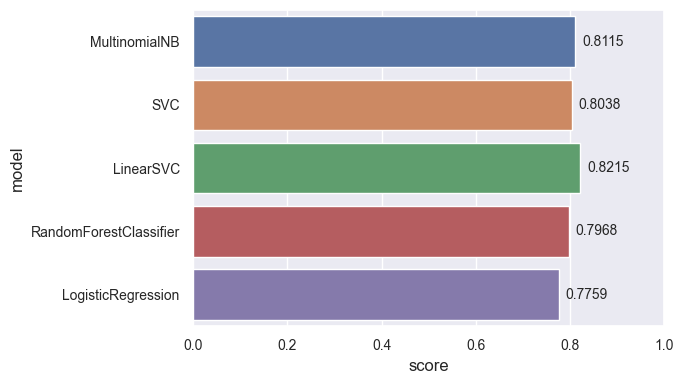

In [20]:
plt.figure(figsize=(7,4))

metrics_plt = sns.barplot(gs_scores, x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, 1)
plt.tight_layout()
plt.show()

We can see that almost all models had a very small increase in their performance. It appears that the best performing model is `LinearSVC`.

## Results and Visualizations

Now that we initialized our models, let's try them out on the complete dataset of job posts that we have.

### Noun Chunk Extraction

In [21]:
gr_chars = "ΑαΆάΒβΓγΔδΕεΈέΖζΗηΉήΘθΙιΊίΚκΛλΜμΝνΞξΟοΌόΠπΡρΣσςΤτΥυΎύΦφΧχΨψΩωΏώ"

def remove_greek(desc):
    translation_table = dict.fromkeys(map(ord, gr_chars), None)
    return desc.translate(translation_table)

# Remove Greek words as the ads were meant for Greece
complete_df['description'] = complete_df['description'].apply(lambda x: remove_greek(x))

In [22]:
# Use regex to remove unwanted formating
replacements = {
    'e.g.': '', 'i.e.': '',                                           # Remove usual examples
    r'\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b': '',                            # Remove e-mails
    r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)': '',  # Remove links
    r'\B#([a-z0-9]{1,})': '',                                         # Remove hashtags
    r'[^\w\s+#]': ' ',                                                # Remove special characters
    r'(\s{2,})|(\n+)': ' '                                            # Remove new lines and whitespaces
}

complete_df['description'] = complete_df['description'].replace(replacements, regex=True)

In [23]:
nlp = spacy.load("en_core_web_sm")

noun_phrases = []
for doc in nlp.pipe(complete_df['description'].astype('unicode').values, batch_size=50, n_process=6):
    assert doc.has_annotation("DEP")
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text)

complete_df = pd.DataFrame(list(noun_phrases), columns=["chunks"])
print(f'Amount of noun chunks extracted: {len(complete_df)}')

Amount of noun chunks extracted: 31841


### Predictions

Let's see the frequency of the top extracted hard skills ngrams.

In [24]:
X_dataset_vec = vectorizer.transform(complete_df['chunks'])
X_dataset_vec.shape

(31841, 4939)

In [25]:
best_model = models[gs_scores['score'].idxmax()]

y_pred = best_model.predict(X_dataset_vec)
complete_df['prediction'] = y_pred

Let's use the `CountVectorizer` model to exctract the most common "hard_skill" unigrams and bigrams from our predictions.

In [26]:
def compute_frequencies(category: int):
    count_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word', stop_words='english')
    sparse_matrix = count_vectorizer.fit_transform(complete_df[complete_df['prediction']==category]['chunks'])
    frequencies = sum(sparse_matrix).toarray()[0]
    ngrams = pd.DataFrame(frequencies, index=count_vectorizer.get_feature_names_out(), columns=['frequency'])
    return ngrams.sort_values(by='frequency', ascending=False)

compute_frequencies(1)[:10]

,frequency
experience,859
data,685
ability,224
analytics,212
skills,210
english,204
tools,202
sql,197
science,197
analysis,171


### Wordcloud Visualizations

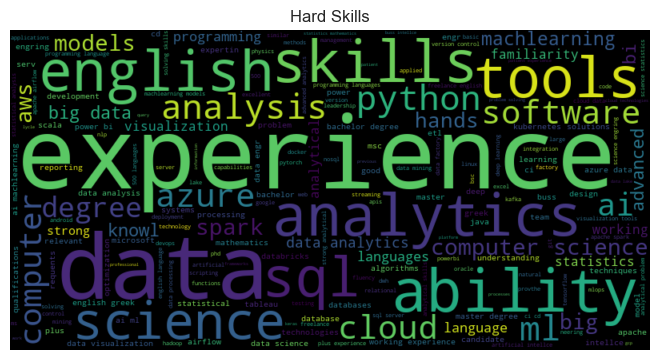

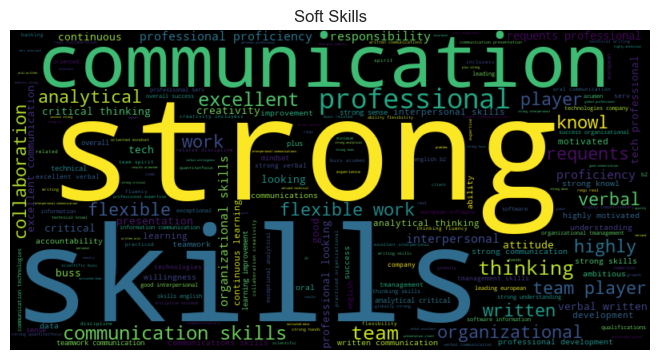

In [27]:
for category in range(1, 3):
    category_names = {
        1: 'Hard Skills',
        2: 'Soft Skills'
    }
    
    word_dict = compute_frequencies(category).to_dict()['frequency']
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_dict)

    # Display wordcloud graphic
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category_names[category])
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

As we can see, our classifier was able to categorize a lot of useful hard and soft skills out of the noun phrases.<br>
In the next notebooks, I will attempt to improve the classification task, by introducing neural network architectures.